In [1]:
from torchvision import models
from image import load_image
import matplotlib.pyplot as plt
from model import ModelWithActivations
from tqdm import tqdm
import numbers
import math

dream_model = ModelWithActivations(models.vgg16(pretrained=True))#models.googlenet(weights='DEFAULT'))

C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch
import numpy as np
import scipy.ndimage as nd

def prepare_input_image(input_image: np.ndarray):
    input_image = torch.from_numpy(input_image)
    input_image = torch.unsqueeze(input_image, 0) # minibatch
    input_image.requires_grad = True
    return input_image

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

In [31]:
from torchmetrics.functional import total_variation
def train_dream(dream_model, input_image, iterations=10, jitter=30):
    input_image.requires_grad = True
    size = input_image.shape[-2] * input_image.shape[-1]
    for iteration in tqdm(range(iterations)):
        out = dream_model(input_image)
        activations = dream_model.get_all_activations()[-1][:, [71, 208]]
#         print(activations[0, [1, 71, 208]])#[1, 71, 208]
        losses = [torch.linalg.vector_norm(activation, ord=2) for activation in activations]
        loss = torch.mean(torch.stack(losses))
        regularization = 100 * total_variation(input_image) / size
        print(loss, regularization)
        loss = loss - regularization #71
        loss.backward()
        grad = input_image.grad.data
#         grad = CascadeGaussianSmoothing(kernel_size=9, sigma=1.6)(grad)
        grad = 1.5 / torch.mean(torch.abs(grad)) * grad
        input_image.data += 0.1*grad
        input_image.grad.data.zero_()
        
    return input_image

In [32]:
image = load_image("examples/sky.jpg")
image = np.squeeze(image.numpy())

In [33]:
octaves = [image]
octave_n = 2
octave_scale = 1.4
n_iter = 7
for i in range(octave_n-1):
    octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))

detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
for octave, octave_base in enumerate(octaves[::-1]):
    h, w = octave_base.shape[-2:]
    if octave > 0:
        # upscale details from the previous octave
        h1, w1 = detail.shape[-2:]
        detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

    input_image = octave_base+detail
    
    jitter = 30
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    input_image = np.roll(np.roll(input_image, ox, -1), oy, -2) # apply jitter shift
    
    input_image_torch = torch.unsqueeze(torch.from_numpy(input_image), 0)
    input_image_torch = train_dream(dream_model, input_image_torch, n_iter)
    input_image = np.squeeze(input_image_torch.detach().numpy())
    
    input_image = np.roll(np.roll(input_image, -ox, -1), -oy, -2)
    detail = input_image-octave_base

  0%|                                                                          | 0/7 [00:00<?, ?it/s]

tensor(0.2339, grad_fn=<MeanBackward0>) tensor(25.7900, grad_fn=<DivBackward0>)


 14%|█████████▍                                                        | 1/7 [00:04<00:27,  4.53s/it]

tensor(0.2500, grad_fn=<MeanBackward0>) tensor(108.6748, grad_fn=<DivBackward0>)


 29%|██████████████████▊                                               | 2/7 [00:09<00:24,  4.89s/it]

tensor(3.0778, grad_fn=<MeanBackward0>) tensor(116.6058, grad_fn=<DivBackward0>)


 43%|████████████████████████████▎                                     | 3/7 [00:14<00:19,  4.97s/it]

tensor(7.1586, grad_fn=<MeanBackward0>) tensor(125.4058, grad_fn=<DivBackward0>)


 57%|█████████████████████████████████████▋                            | 4/7 [00:19<00:14,  4.90s/it]

tensor(9.9798, grad_fn=<MeanBackward0>) tensor(132.4489, grad_fn=<DivBackward0>)


 71%|███████████████████████████████████████████████▏                  | 5/7 [00:24<00:09,  4.95s/it]

tensor(12.9140, grad_fn=<MeanBackward0>) tensor(144.9708, grad_fn=<DivBackward0>)


 86%|████████████████████████████████████████████████████████▌         | 6/7 [00:29<00:04,  4.99s/it]

tensor(14.2658, grad_fn=<MeanBackward0>) tensor(152.5038, grad_fn=<DivBackward0>)


  0%|                                                                          | 0/7 [00:00<?, ?it/s]

tensor(5.5726, grad_fn=<MeanBackward0>) tensor(86.7111, grad_fn=<DivBackward0>)


 14%|█████████▍                                                        | 1/7 [00:09<00:58,  9.68s/it]

tensor(9.4563, grad_fn=<MeanBackward0>) tensor(132.6672, grad_fn=<DivBackward0>)


 29%|██████████████████▊                                               | 2/7 [00:19<00:47,  9.51s/it]

tensor(12.7595, grad_fn=<MeanBackward0>) tensor(146.6582, grad_fn=<DivBackward0>)


 43%|████████████████████████████▎                                     | 3/7 [00:28<00:37,  9.29s/it]

tensor(18.0111, grad_fn=<MeanBackward0>) tensor(158.6484, grad_fn=<DivBackward0>)


 57%|█████████████████████████████████████▋                            | 4/7 [00:37<00:27,  9.33s/it]

tensor(19.9219, grad_fn=<MeanBackward0>) tensor(166.8387, grad_fn=<DivBackward0>)


 71%|███████████████████████████████████████████████▏                  | 5/7 [00:48<00:19,  9.82s/it]

tensor(25.0071, grad_fn=<MeanBackward0>) tensor(173.7673, grad_fn=<DivBackward0>)


 86%|████████████████████████████████████████████████████████▌         | 6/7 [01:01<00:11, 11.07s/it]

tensor(28.3729, grad_fn=<MeanBackward0>) tensor(178.8296, grad_fn=<DivBackward0>)


100%|██████████████████████████████████████████████████████████████████| 7/7 [01:15<00:00, 10.85s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


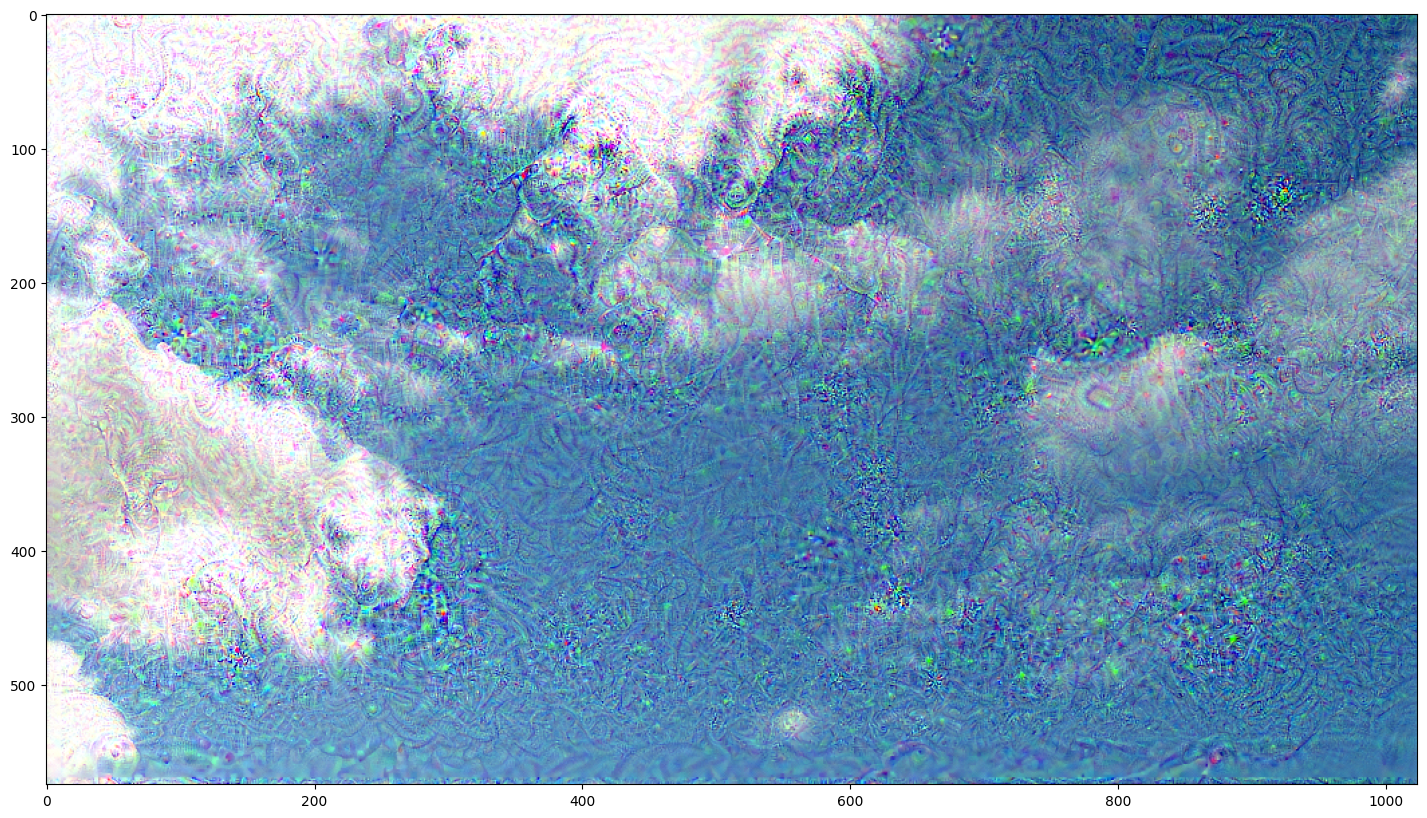

In [37]:
plt.figure(figsize=(20, 10))
img = np.moveaxis(deprocess(input_image), 0, -1)
plt.imshow(img)

In [35]:
def deprocess(image):
    img = image.copy()
    img[0, :, :] *= 0.229
    img[1, :, :] *= 0.224
    img[2, :, :] *= 0.225
    img[0, :, :] += 0.485
    img[1, :, :] += 0.456
    img[2, :, :] += 0.406
    return img
    
    